This notebook extracts features of narrative elements that we’ve defined from our hypotheses to use as predictors in a logistic regression model to understand element importance. 


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from apyori import apriori
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet 
from nltk.corpus import sentiwordnet as swn
from collections import Counter
from textblob import TextBlob

### Import TripAdvisor dataset (currently one csv file from each city)

In [2]:
filepath = ['reviews/Chicago_Illinois_1.csv', 'reviews/Las_Vegas_Nevada_1.csv', \
            'reviews/New_York_City_New_York_1.csv', 'reviews/San_Francisco_California_1.csv']

data = pd.DataFrame()
for path in filepath:
    df = pd.read_csv(path)
    df['city'] = path.split('/')[1]
    data = data.append(df)
data.shape #247,637 rows, 19 columns

(247637, 19)

In [3]:
#data.isnull().sum()
del data['neighborhood'] #remove column given 80+% null

In [4]:
#Make sure every sentence ends in a period and every review is split into sentences
#for cases such as {961, 869, 871, 809, 717, 494, 911, 720, 818, 340, 634, 310, 442, 990}
#data['review_body'] = data['review_body']+'.'
data['review_body'] = [x.split('.') for x in data['review_body']]

### Import LIWC scores for each csv

In [5]:
filepath_LIWC = ['reviews/LIWC_scores_Chicago_Illinois_1.csv', 'reviews/LIWC_scores_Las_Vegas_Nevada_1.csv', \
            'reviews/LIWC_scores_New_York_City_New_York_1.csv', 'reviews/LIWC_scores_San_Francisco_California_1.csv']
consciousness = pd.DataFrame()
for path in filepath_LIWC:
    d = pd.read_csv(path)
    d['city'] = path.split('/')[1]
    consciousness = consciousness.append(d)

consciousness.shape

(247637, 45)

In [6]:
# Drop redundant columns from dataframe
consciousness.drop(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
                   'R'], axis=1, inplace=True)
consciousness.shape

(247637, 27)

### Read in NRC Emotion Lexicon

In [7]:
with open('NRC-Emotion-Lexicon-Wordlevel-v0.92.csv', 'r') as f:
    df = pd.read_csv(f, delimiter='\t',
                     header=0,
                     names=['word', 'emotion', 'relation'])

# Create lists of emotion words
#(anger, fear, anticipation, trust, surprise, sadness, joy, and disgust)
anticipation = list(df[(df['emotion']=='anticipation') & (df['relation']!=0)]['word'])
anger = list(df[(df['emotion']=='anger') & (df['relation']!=0)]['word'])
fear = list(df[(df['emotion']=='fear') & (df['relation']!=0)]['word'])
trust = list(df[(df['emotion']=='trust') & (df['relation']!=0)]['word'])
surprise = list(df[(df['emotion']=='surprise') & (df['relation']!=0)]['word'])
sadness = list(df[(df['emotion']=='sadness') & (df['relation']!=0)]['word'])
joy = list(df[(df['emotion']=='joy') & (df['relation']!=0)]['word'])
disgust = list(df[(df['emotion']=='disgust') & (df['relation']!=0)]['word'])
neg_NRC = list(df[(df['emotion']=='negative') & (df['relation']!=0)]['word'])
pos_NRC = list(df[(df['emotion']=='positive') & (df['relation']!=0)]['word'])

In [11]:
print('There are ' + str(len(anticipation)) + ' anticipation words.')
print('There are ' + str(len(anger)) + ' anger words.')
print('There are ' + str(len(fear)) + ' fear words.')
print('There are ' + str(len(trust)) + ' trust words')
print('There are ' + str(len(surprise)) + ' surprise words')
print('There are ' + str(len(sadness)) + ' sadness words')
print('There are ' + str(len(joy)) + ' joy words')
print('There are ' + str(len(disgust)) + ' disgust words')
print('There are ' + str(len(neg_NRC)) + ' negative words')
print('There are ' + str(len(pos_NRC)) + ' positive words')

There are 839 anticipation words.
There are 1247 anger words.
There are 1476 fear words.
There are 1231 trust words
There are 534 surprise words
There are 1191 sadness words
There are 689 joy words
There are 1058 disgust words
There are 3324 negative words
There are 2312 positive words


### Pre-process Text

In [8]:
# Tokenize and tag each sentence in review with part of speech tags.
all_sent = []
for item in data['review_body']:
    tagged_sent = []
    for sent in item:
        tokenized = nltk.word_tokenize(sent)
        tagged=nltk.pos_tag(tokenized)
        tagged_sent.append(tagged)
    all_sent.append(tagged_sent)

In [10]:
with open("tagged_sent.csv", 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_sent)

### Extract features
Feature details: https://docs.google.com/document/d/1xbN-xf9eeJsqsfqzynQt1KcV51cy0TLiaX3lAP8evBE/edit?usp=sharing 

In [12]:
reviews = []
sentences = []
# Initiate empty list for subjectivity features
nouns = []
adj = []
comparatives = []
superlatives = []
adverbs = []
word_count = []
ne = []
tense = []
polarity = []
dt = []

# Initiate empty list for trauma narrative features
past_tense = []
first_person_plural = []
third_person_prn=[]
negative_words = []
positive_words = []

# Initiate empty list for TextBlob scores
subjectivity = []
polarity2 = []

# Initiate empty list for NRC Emotion / Plutchik’s scale of emotion
tot_anger = []
tot_fear = []
tot_anticipation = []
tot_trust = []
tot_surprise = []
tot_sadness = []
tot_joy = []
tot_disgust = []
tot_neg_NRC = []
tot_pos_NRC = []

untagged_sent = []
count=0

In [ ]:
for rev in all_sent:
    count+=1
    #print(rev)
    for sent in rev:
        if len(sent)==0:
            pass
        else:
            #print(sent)
            reviews.append(count)
            # Append sentence
            sentences.append(sent)
            # Get word count
            word_count.append(len(sent))

            counts = Counter(x[1] for x in sent)
            total_nouns = counts['NN'] + counts['NNS'] + counts['NNP'] + counts['NNPS']
            nouns.append(total_nouns)
            #print('total nouns: ' + str(total_nouns))

            total_adj = counts['JJ'] + counts['JJR'] + counts['JJS']
            adj.append(total_adj)
            #print('total adj: ' + str(total_adj))

            total_comparatives = counts['JJR']
            comparatives.append(total_comparatives)
            #print('total comparatives: ' + str(total_comparatives))

            total_superlatives = counts['JJS']
            superlatives.append(total_superlatives)
            #print('total superlatives: ' + str(total_superlatives))

            total_adv = counts['RB']+ counts['RBR'] + counts['RBS']
            adverbs.append(total_adv)
            #print('total adv: ' + str(total_adv))
            
            # Get named entities
            ne_tree =  nltk.ne_chunk(sent)
            ne_list = list(ne_tree)
            counts_ne = Counter(list(ne_list[i])[0][1] for i in range(len(ne_list)) \
                                if type(ne_list[i]) is nltk.tree.Tree)
            total_ne = counts_ne['NNP']
            ne.append(total_ne)
            
            count_future = counts['MD']
            #print('future words: ' + str(count_future))
            count_present = counts['VBP'] + counts['VBG'] + counts['VBZ']
            #print('present words: ' + str(count_present))
            count_past = counts['VBD'] + counts ['VBN']
            past_tense.append(count_past)
            #print('past words: ' + str(count_past))
            # Get max count from future, present, and past, and use as tense of sentence.
            tense_count = max(count_future, count_present, count_past)
            #print('max: ' + str(tense_count))
            if tense_count == count_future:
                tense.append('future')
                #print('this sentence is written in future tense')
            elif tense_count == count_present:
                tense.append('present')
                #print('this sentence is written in present tense')
            else:
                tense.append('past')
                #print('this sentence is written in past tense')
            
            # CD represents cardinal numbers
            count_dt = counts['CD']
            dt.append(count_dt)
            #print('total digits: ' + str(count_dt))
            
            count_fp = Counter(x[0] for x in sent if x[0] in ['we','us','our'])
            first_person_plural.append(sum(count_fp.values()))
            #print('total first person pronoun words: ' + str(sum(count_fp.values())))
            
            count_tp = Counter(x[0] for x in sent if x[0] in ['he','she','it','him','her','his','hers','its','they',\
                                                              'them','their','theirs'])            
            third_person_prn.append(sum(count_tp.values()))
            
            # Determine polarity of sentence. Count the number of words from SentiWordNet 
            # (having either nonzero positive polarity score or nonzero negative polarity score) 
            # present in a sentence
            sent_pos = 0
            sent_neg = 0
            for word in sent:
                #print(word)
                pos_list = []
                neg_list = []
                # Get word synonyms
                syns = wordnet.synsets(word[0])
                if syns == []:
                    pass
                else:
                    # Append all polarity scores for each word and take the max positive and negative
                    # to use as overall word polarity. 
                    for s in syns:
                        #print(s.name)
                        swn_synset =swn.senti_synset(s.name())
                        pos_list.append(swn_synset.pos_score())
                        neg_list.append(swn_synset.neg_score())
                        #print('Positive: ' + str(pos_list))
                        #print('Negative: ' + str(neg_list))
                    word_pos = max(pos_list)
                    #print('Positive max: ' + str(word_pos))
                    word_neg = max(neg_list)
                    #print('Negative max: ' + str(word_neg))
                    if word_pos > word_neg:
                        sent_pos +=1
                    if word_neg > word_pos:
                        sent_neg +=1
            negative_words.append(sent_neg)
            positive_words.append(sent_pos)
            # Sum up number of positive and negative words in sentence
            total_polarity = sent_pos+sent_neg
            polarity.append(total_polarity)
            
            # NRC Emotions: anger, fear, anticipation, trust, surprise, sadness, joy, and disgust
            count_ant = Counter(x[0] for x in sent if x[0] in anticipation)
            tot_anticipation.append(sum(count_ant.values()))
            count_anger = Counter(x[0] for x in sent if x[0] in anger)
            tot_anger.append(sum(count_anger.values()))
            count_fear = Counter(x[0] for x in sent if x[0] in fear)
            tot_fear.append(sum(count_fear.values()))
            count_trust = Counter(x[0] for x in sent if x[0] in trust)
            tot_trust.append(sum(count_trust.values()))
            count_surprise = Counter(x[0] for x in sent if x[0] in surprise)
            tot_surprise.append(sum(count_surprise.values()))
            count_sad = Counter(x[0] for x in sent if x[0] in sadness)
            tot_sadness.append(sum(count_sad.values()))
            count_joy = Counter(x[0] for x in sent if x[0] in joy)
            tot_joy.append(sum(count_joy.values()))
            count_disgust = Counter(x[0] for x in sent if x[0] in disgust)
            tot_disgust.append(sum(count_disgust.values()))
            count_neg = Counter(x[0] for x in sent if x[0] in neg_NRC)
            tot_neg_NRC.append(sum(count_neg.values()))
            count_pos = Counter(x[0] for x in sent if x[0] in pos_NRC)
            tot_pos_NRC.append(sum(count_pos.values()))
            
            # Use TextBlob to sentence-level subjectivity and polarity scores
            # Each word in the lexicon has scores for:
            # 1) polarity: negative vs. positive    (-1.0 => +1.0)
            # 2) subjectivity: objective vs. subjective (+0.0 => +1.0)
            new_sent = " ".join([a for a, b in sent])
            text = TextBlob(new_sent)
            untagged_sent.append(new_sent)
            subjectivity.append(text.sentiment.subjectivity)
            polarity2.append(text.sentiment.polarity)
            
            
print(count)

In [ ]:
count

In [24]:
print(len(reviews))
print(len(sentences))
print(len(negative_words))
print(len(subjectivity))

600668
600668
600667
600667


In [ ]:
# Create a dataframe of sentence-level records
setup = {'Reviews':reviews, 'Sentence':sentences, 'Untagged': untagged_sent, \
         'Word_Count': word_count, 'Nouns': nouns, 'Adjectives':adj, \
         'Comparatives': comparatives, 'Superlatives':superlatives, 'Adverbs': adverbs,\
         'Subjectivity': subjectivity, 'Tense': tense, 'Digits': dt, \
         'Polarity': polarity, 'Polarity2': polarity2, 'First Person': first_person_plural,    
         'Named Entities': ne, 'Third Person': third_person_prn, 'Past Tense': past_tense,
         'Neg_Words': negative_words}
opinions = pd.DataFrame(setup)    

In [ ]:
len(opinions['Reviews'].unique())

In [ ]:
opinions.to_csv('opinions_features_1_all', sep=',')
#opinions_csv = pd.read_csv('opinions_features_1_updated')
#opinions_csv.head()

In [25]:
results_1 = pd.read_csv('opinions_features_1_87282')
results_2 = pd.read_csv('opinions_features_1_remaining')
results_1['actual_rev_no'] = results_1['Reviews']-1
results_2['actual_rev_no'] = results_2['Reviews']+87280
result = pd.concat([results_1, results_2])
#remove overlap
result[result['actual_rev_no']==87281].drop([600665, 600666])

,Unnamed: 0,Adjectives,Adverbs,Comparatives,Digits,First Person,Named Entities,Neg_Words,Nouns,Past Tense,...,Polarity2,Reviews,Sentence,Subjectivity,Superlatives,Tense,Third Person,Untagged,Word_Count,actual_rev_no
0,0,2,0,0,0,0,1,1,4,0,...,0.000000,1,"[('We', 'PRP'), ('are', 'VBP'), ('diamond', 'J...",0.000000,1,present,0,"We are diamond players , this is Harrah 's fin...",14,87281
1,1,2,1,0,0,0,0,2,2,0,...,1.000000,1,"[('The', 'DT'), ('rooms', 'NNS'), ('are', 'VBP...",1.000000,0,present,0,The rooms are always immaculate and the amenit...,10,87281
2,2,2,2,0,0,0,0,3,3,0,...,0.537500,1,"[('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'...",0.675000,0,present,0,This place is gorgeous not feminine beautiful ...,9,87281
3,3,0,2,0,0,0,0,3,2,0,...,0.350000,1,"[('I', 'PRP'), ('love', 'VBP'), ('staying', 'V...",0.400000,0,present,0,I love staying here the grounds are really som...,9,87281
4,4,1,2,0,0,0,0,2,3,0,...,0.416667,1,"[('Treat', 'NN'), ('yourself', 'PRP'), ('to', ...",0.500000,0,future,1,Treat yourself to a fine room and meal here yo...,14,87281
5,5,0,0,0,0,0,1,2,3,0,...,0.500000,1,"[('My', 'PRP$'), ('husband', 'NN'), ('and', 'C...",0.600000,0,present,0,My husband and I love the Mermaid Bar,8,87281
6,6,1,4,0,0,1,0,6,6,2,...,0.166667,1,"[('We', 'PRP'), ('actually', 'RB'), ('have', '...",0.466667,0,present,0,"We actually have won money here , playing vide...",26,87281
7,7,0,1,0,0,0,0,3,1,0,...,0.000000,1,"[('A', 'DT'), ('lot', 'NN'), ('to', 'TO'), ('s...",0.000000,0,future,0,A lot to see and do here,7,87281


In [26]:
# Aggregate sentence-level dataframe back into review-level
aggregation_functions = {'Adjectives': 'sum', 'Adverbs': 'sum', 'Comparatives': 'sum', 'Superlatives': 'sum',
                        'Digits': 'sum', 'Nouns': 'sum', 'Polarity': 'sum', 'Polarity2': 'mean',
                        'Subjectivity': 'mean', 'Tense': lambda col: ', '.join(col), 'Word_Count': 'sum',
                        'First Person': 'sum', 'Named Entities': 'sum', 'Third Person': 'sum', 'Past Tense': 'sum',
                        'Neg_Words': 'sum'}
df1 = result.groupby(result['actual_rev_no']).agg(aggregation_functions)

In [12]:
df1.iloc[3]

Adjectives                                                       10
Adverbs                                                           8
Comparatives                                                      1
Superlatives                                                      0
Digits                                                            2
Nouns                                                            38
Polarity                                                         72
Polarity2                                                  0.294643
Subjectivity                                               0.503571
Tense             past, present, present, present, present, pres...
Word_Count                                                      156
First Person                                                      1
Named Entities                                                    6
Third Person                                                      6
Past Tense                                      

In [13]:
data.iloc[3]['review_body']

['My ol lady got a trip off orbits for me and my brothers to get out of town for my 40th birthday just to Dick around',
 ' Anyway this is a trendy boutique hotel',
 ' The room art is way to hip for me but I loved the bathrooms',
 ' Service was ok everybody’s too cool for school is the vibe they give out which is what they are trying to push',
 ' The real reason I didn’t give it a higher rating is because all hotels are now trying these signature scents by pumping out these smells thru diffusers and while I love the Ritz and Four Seasons scents the one the Thompson uses is absolutely horrible and inundates every corner of the hotel',
 ' Maybe they have changed it since I have been there but it that’s why the 3 star rating',
 ' Also we saw Brian Glazer in the lobby which was cool',
 '']

In [28]:
print(set(list(range(0,247637))) - set(list(df1.index.unique())))

{0}


In [27]:
# Make values percentages
df2 = df1[['Adjectives','Adverbs', 'Comparatives', 'Superlatives', 'Digits', 'Nouns', 'Polarity',
   'Named Entities']].div(df1.Word_Count, axis=0)

In [28]:
df2['Tense'] = df1['Tense']
df2['Polarity2'] = df1['Polarity2']
df2['Subjectivity'] = df1['Subjectivity']
df2['Word_Count'] = df1['Word_Count']
df2['First Person'] = df1['First Person']
df2['Third Person'] = df1['Third Person']
df2['Past Tense'] = df1['Past Tense']
df2['Neg_Words'] = df1['Neg_Words']
df2.head()

,Adjectives,Adverbs,Comparatives,Superlatives,Digits,Nouns,Polarity,Named Entities,Tense,Polarity2,Subjectivity,Word_Count,First Person,Third Person,Past Tense,Neg_Words
actual_rev_no,,,,,,,,,,,,,,,,
0,0.095238,0.000000,0.00000,0.0,0.000000,0.333333,0.365079,0.063492,"past, past, past",0.475000,0.608333,63,2,0,6,12
1,0.125000,0.031250,0.00000,0.0,0.031250,0.250000,0.453125,0.031250,"present, past, present, past",0.473750,0.936250,64,1,0,5,11
2,0.127273,0.054545,0.00000,0.0,0.018182,0.200000,0.490909,0.036364,"past, present, past, future",0.432812,0.618750,55,0,0,5,7
3,0.064103,0.051282,0.00641,0.0,0.012821,0.243590,0.461538,0.038462,"past, present, present, present, present, pres...",0.294643,0.503571,156,1,6,7,28
4,0.053571,0.089286,0.00000,0.0,0.017857,0.258929,0.348214,0.035714,"past, present, present, present, past, past, f...",0.460159,0.604286,112,3,2,7,16


In [29]:
len(df2)

247637

In [11]:
# Reindex consciousness and data df
consciousness['Reviews'] = df2.index.values
consciousness.set_index('Reviews', inplace=True)
data['Reviews'] = df2.index.values
data.set_index('Reviews', inplace=True)


In [32]:
# create column for Narrative to denote presence of narrative (sum of 
# past tense, perfect, and third person pronoun variables)
df2['Narrative'] = df2['Past Tense'] + df2['Third Person']
df2['Tense'] = [Counter(i.split(', ')).most_common()[0][0] for i in df2['Tense']]
df2['affect'] = consciousness['affect']*.01
df2['posemo'] = consciousness['posemo']*.01
df2['negemo'] = consciousness['negemo']*.01
df2['Trauma'] = [1 if (df2.iloc[i]['Narrative']>0) and (df2.iloc[i]['Neg_Words']>0) 
                 and (df2.iloc[i]['First Person']>0) else 0 for i in range(len(df2))]
df2['anx'] = consciousness['anx']*.01*.01
df2['anger'] = consciousness['anger']*.01
df2['sad'] = consciousness['sad']*.01 #[:8088]
df2['cogproc'] = consciousness['cogproc']*.01 #[:8088]
df2['insight'] = consciousness['insight']*.01 #[:8088]
df2['cause'] = consciousness['cause']*.01 #[:8088]
df2['discrep'] = consciousness['discrep']*.01 #[:8088]
df2['tentat'] = consciousness['tentat']*.01 #[:8088]
df2['certain'] = consciousness['certain']*.01 #[:8088]
df2['differ'] = consciousness['differ']*.01 #[:8088]
df2['Rating'] = data['rating'] #[:8088]
df2['Helpful'] = data['helpful_vote'] #[:8088]
df2['city'] = data['city']

In [13]:
df2['affect'].describe()

count    247637.000000
mean          0.076171
std           0.039912
min           0.000000
25%           0.048100
50%           0.069400
75%           0.097600
max           0.472200
Name: affect, dtype: float64

In [33]:
# Remove rows with rating of 3
df2 = df2[df2.Rating != 30]
df2.shape

(217206, 34)

In [34]:
df2['Rating'] = df2['Rating'].map({50: 1, 40: 1, 20: 0, 10: 0})
df2['Tense'] = df2['Tense'].map({'past': -1, 'present': 2, 'future': 3})
df2['city'] = df2['city'].map({'Chicago_Illinois_1.csv': 1, 'New_York_City_New_York_1.csv': 2, 
                              'San_Francisco_California_1.csv': 3, 'Las_Vegas_Nevada_1.csv': 4})

In [35]:
#print(consciousness.columns)

consciousness['spatial'] = [2 if (consciousness.iloc[s]['space'] > 0) & (consciousness.iloc[s]['percept'] > 0) 
                            else 1 if (consciousness.iloc[s]['space'] > 0) & (consciousness.iloc[s]['percept'] == 0) 
                            else 0 for s in range(len(consciousness))]
consciousness['temporal'] = [2 if (consciousness.iloc[s]['time'] > 0) & (consciousness.iloc[s]['cause'] > 0) 
                            else 1 if (consciousness.iloc[s]['time'] > 0) | (consciousness.iloc[s]['cause'] > 0) 
                            else 0 for s in range(len(consciousness))]

In [36]:
df2['spatial'] = consciousness['spatial']
df2['temporal'] = consciousness['temporal']

In [16]:
df2 = pd.read_csv('Chi_NYC_LV_SF_features_1', sep=',')

In [37]:
print('Number of positive reviews: ' + str(len(df2[df2['Rating'] == 1])))
print('Number of negative reviews: ' + str(len(df2[df2['Rating'] == 0])))
print('% of positive: ' + str(round((len(df2[df2['Rating'] == 1])/(len(df2[df2['Rating'] == 1])+len(df2[df2['Rating'] == 0])))*100,2)))

Number of positive reviews: 191625
Number of negative reviews: 25581
% of positive: 88.22


## Use Features to Predict Sentiment

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.utils import resample

In [77]:
#df1 = df1.drop(61464, axis=0)

In [46]:
df2.columns

Index(['Adjectives', 'Adverbs', 'Comparatives', 'Superlatives', 'Digits',
       'Nouns', 'Polarity', 'Named Entities', 'Tense', 'Polarity2',
       'Subjectivity', 'Word_Count', 'First Person', 'Third Person',
       'Past Tense', 'Neg_Words', 'Narrative', 'affect', 'posemo', 'negemo',
       'Trauma', 'anx', 'anger', 'sad', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'Rating', 'Helpful', 'city',
       'spatial', 'temporal'],
      dtype='object')

In [51]:
y = df2['Rating']
X = df2[['Polarity2','Subjectivity', 'Word_Count', 'Named Entities',
       'affect', 'cogproc','Helpful', 'city', 'Trauma','spatial', 'temporal', 'Third Person', 'Past Tense']]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(metrics.classification_report(y_test, y_pred))


Accuracy of logistic regression classifier on test set: 0.94
[[ 4690  2984]
 [ 1223 56265]]
             precision    recall  f1-score   support

          0       0.79      0.61      0.69      7674
          1       0.95      0.98      0.96     57488

avg / total       0.93      0.94      0.93     65162



In [43]:
results_df = X_test
results_df['y_test']= y_test
results_df['y_pred']=y_pred

/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
incorrects = results_df[results_df['y_test']!=results_df['y_pred']]

In [55]:
false_positives = incorrects[(incorrects['y_test']==0) & (incorrects['y_pred']==1)]
false_negatives = incorrects[(incorrects['y_test']==1) & (incorrects['y_pred']==0)]
true_positives = results_df[(results_df['y_test']==1) & (results_df['y_pred']==1)]
true_negatives = results_df[(results_df['y_test']==0) & (results_df['y_pred']==0)]

In [59]:
from statistics import mean 
print('False+ | Polarity2: ' + str(mean(false_positives.Polarity2)) + ' True- |' +str(mean(true_negatives.Polarity2)))
print('False+ | Subjectivity: ' + str(mean(false_positives.Subjectivity))+ ' True- |' +str(mean(true_negatives.Subjectivity)))
print('False+ | Word_Count: ' + str(mean(false_positives.Word_Count))+ ' True- |' +str(mean(true_negatives.Word_Count)))
print('False+ | Helpful: ' + str(mean(false_positives.Helpful))+ ' True- |' +str(mean(true_negatives.Helpful)))
print('False+ | affect: ' + str(mean(false_positives.affect))+ ' True- |' +str(mean(true_negatives.affect)))
print('False+ | cogproc: ' + str(mean(false_positives.cogproc))+ ' True- |' +str(mean(true_negatives.cogproc)))
print('False+ | Trauma: ' + str(mean(false_positives.Trauma))+ ' True- |' +str(mean(true_negatives.Trauma)))
print('False+ | spatial: ' + str(mean(false_positives.spatial))+ ' True- |' +str(mean(true_negatives.spatial)))
print('False+ | temporal: ' + str(mean(false_positives.temporal))+ ' True- |' +str(mean(true_negatives.temporal)))
            

False+ | Polarity2: 0.1273470619787051 True- |-0.07703048821232189
False+ | Subjectivity: 0.4150246935799466 True- |0.3835847759708672
False+ | Word_Count: 142 True- |176
False+ | Helpful: 19 True- |10
False+ | affect: 0.05199510333863275 True- |0.04454327666151468
False+ | cogproc: 0.10042445151033387 True- |0.10040991388827555
False+ | Trauma: 0 True- |0
False+ | spatial: 1 True- |1
False+ | temporal: 1 True- |1


In [60]:
print('False- | Polarity2: ' + str(mean(false_negatives.Polarity2))+ ' True+ |' +str(mean(true_positives.Polarity2)))
print('False- | Subjectivity: ' + str(mean(false_negatives.Subjectivity))+ ' True+ |' +str(mean(true_positives.Subjectivity)))
print('False- | Word_Count: ' + str(mean(false_negatives.Word_Count))+ ' True+ |' +str(mean(true_positives.Word_Count)))
print('False- | Helpful: ' + str(mean(false_negatives.Helpful))+ ' True+ |' +str(mean(true_positives.Helpful)))
print('False- | affect: ' + str(mean(false_negatives.affect))+ ' True+ |' +str(mean(true_positives.affect)))
print('False- | cogproc: ' + str(mean(false_negatives.cogproc))+ ' True+ |' +str(mean(true_positives.cogproc)))
print('False- | Trauma: ' + str(mean(false_negatives.Trauma))+ ' True+ |' +str(mean(true_positives.Trauma)))
print('False- | spatial: ' + str(mean(false_negatives.spatial))+ ' True+ |' +str(mean(true_positives.spatial)))
print('False- | temporal: ' + str(mean(false_negatives.temporal))+ ' True+ |' +str(mean(true_positives.temporal)))
            

False- | Polarity2: -0.022712984152377387 True+ |0.3127465107601093
False- | Subjectivity: 0.3794892041400024 True+ |0.5177233922593242
False- | Word_Count: 165 True+ |100
False- | Helpful: 13 True+ |18
False- | affect: 0.04686406124093473 True+ |0.08354321652710367
False- | cogproc: 0.10795028203062047 True+ |0.08189278361512614
False- | Trauma: 0 True+ |0
False- | spatial: 1 True+ |1
False- | temporal: 1 True+ |1


In [67]:
incorrects['review_body']=np.nan
incorrects['city']=np.nan
incorrects['5_pt_rating']=np.nan

/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [65]:
incorrects.index.values

array([ 43473, 183868, 204516, ...,  17421, 231850, 175507])

In [68]:
for i in incorrects.index.values:
    #print(data.loc[[i],['review_body']])
    incorrects['review_body'].loc[i] = data.loc[i]['review_body']
    incorrects['city'].loc[i] = data.loc[i]['city']
    incorrects['5_pt_rating'].loc[i] = data.loc[i]['rating']
    


/Users/arthur/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

In [74]:
df2.columns

Index(['Adjectives', 'Adverbs', 'Comparatives', 'Superlatives', 'Digits',
       'Nouns', 'Polarity', 'Named Entities', 'Tense', 'Polarity2',
       'Subjectivity', 'Word_Count', 'First Person', 'Third Person',
       'Past Tense', 'Neg_Words', 'Narrative', 'affect', 'posemo', 'negemo',
       'Trauma', 'anx', 'anger', 'sad', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'Rating', 'Helpful', 'city',
       'spatial', 'temporal'],
      dtype='object')

In [ ]:
incorrects.tail

In [ ]:
incorrects['adjectives']=np.nan
incorrects['comparatives']=np.nan
incorrects['superlatives']=np.nan
incorrects['NE']=np.nan
incorrects['digits']=np.nan
incorrects['polarity2']=np.nan
incorrects['affect']=np.nan
for i in incorrects.index.values:
    incorrects['affect'].loc[i] = df2.loc[i]['affect']
    incorrects['adjectives'].loc[i] = df2.loc[i]['Adjectives']
    incorrects['comparatives'].loc[i] = df2.loc[i]['Comparatives']
    incorrects['superlatives'].loc[i] = df2.loc[i]['Superlatives']
    incorrects['digits'].loc[i] = df2.loc[i]['Digits']
    incorrects['NE'].loc[i] = df2.loc[i]['Named Entities']
    incorrects['Polarity2'].loc[i] = df2.loc[i]['Polarity2']

/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/arthur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
for i in range(10):
    print('Actual: ' + str(incorrects.iloc[i]['y_test']))
    print('Predicted: ' + str(incorrects.iloc[i]['y_pred']))
    print('Review: ' + str(incorrects.iloc[i]['review_body']))
    print('City: ' + str(incorrects.iloc[i]['city']))
    print('Rating: ' + str(incorrects.iloc[i]['5_pt_rating']))
    print('affect: ' + str(incorrects.iloc[i]['affect']))
    print('adjectives: ' + str(incorrects.iloc[i]['Adjectives']))
    print('comparatives: ' + str(incorrects.iloc[i]['Comparatives']))
    print('superlatives: ' + str(incorrects.iloc[i]['Superlatives']))
    print('digits: ' + str(incorrects.iloc[i]['Digits']))
    print('NE: ' + str(incorrects.iloc[i]['Named Entities']))
    print('Polarity2: ' + str(incorrects.iloc[i]['Polarity2']))



In [ ]:
incorrects.to_csv('incorrects', sep=',')

## Up-sample Minority Class (Neg)

In [53]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df2[df2.Rating==1]
df_minority = df2[df2.Rating==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df2[df2['Rating'] == 1]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Rating.value_counts()

1    191625
0    191625
Name: Rating, dtype: int64

In [11]:
#df_upsampled.to_csv('Chi_NYC_LV_SF_features_1_upsampled', sep=',')
df_upsampled = pd.read_csv('Chi_NYC_LV_SF_features_1_upsampled')

In [68]:
#Scale data to determine feature importance
y1 = df_upsampled.Rating
X1 = df_upsampled[['Subjectivity', 'Word_Count', 'Named Entities', 'Polarity2',
       'affect', 'cogproc','Helpful', 'city', 'Trauma','spatial', 'temporal', 'Third Person', 'Past Tense']]
#scaler = RobustScaler()
#scaler.fit(X1) 
#X_scaled1 = pd.DataFrame(scaler.transform(X1),columns = X1.columns)
#X_scaled1.head()

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=0)
logreg1 = LogisticRegression()
logreg1.fit(X_train1, y_train1)
y_pred1 = logreg1.predict(X_test1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg1.score(X_test1, y_test1)))
print("Precision:",metrics.precision_score(y_test1, y_pred1))
print("Recall:",metrics.recall_score(y_test1, y_pred1))
confusion_matrix1 = metrics.confusion_matrix(y_test1, y_pred1)
print(confusion_matrix1)
print(metrics.classification_report(y_test1, y_pred1))


Accuracy of logistic regression classifier on test set: 0.88
Precision: 0.8899360543978015
Recall: 0.8742126393022773
[[50939  6248]
 [ 7269 50519]]
             precision    recall  f1-score   support

          0       0.88      0.89      0.88     57187
          1       0.89      0.87      0.88     57788

avg / total       0.88      0.88      0.88    114975



Precision: how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct.

Recall: if there are positive reviews in the test set, this Logistic Regression model can identify it 86% of the time.

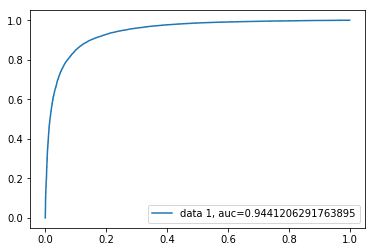

In [18]:
y_pred_proba = logreg1.predict_proba(X_test1)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test1,  y_pred_proba)
auc = metrics.roc_auc_score(y_test1, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

## Down-sample Majority Class (Pos)

In [41]:
df_majority = df2[df2.Rating==1]
df_minority = df2[df2.Rating==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df2[df2['Rating'] == 0]),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Rating.value_counts()

1    25581
0    25581
Name: Rating, dtype: int64

In [97]:
df_downsampled.to_csv('Chi_NYC_LV_SF_features_1_downsampled', sep=',')

In [62]:
#Scale data to determine feature importance
y2 = df_downsampled.Rating
X2 = df_downsampled[['Polarity2',
       'Subjectivity', 'Word_Count',
       'affect', 'cogproc','Helpful', 'city', 'Trauma','spatial', 'temporal']]
#scaler = RobustScaler()
#scaler.fit(X2) 
#X_scaled2 = pd.DataFrame(scaler.transform(X2),columns = X2.columns)
#X_scaled2.head()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)
logreg2 = LogisticRegression()
logreg2.fit(X_train2, y_train2)
y_pred2 = logreg2.predict(X_test2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test2, y_test2)))
confusion_matrix2 = metrics.confusion_matrix(y_test2, y_pred2)
print(confusion_matrix2)
print(metrics.classification_report(y_test2, y_pred2))


Accuracy of logistic regression classifier on test set: 0.87
[[6764  897]
 [1041 6647]]
             precision    recall  f1-score   support

          0       0.87      0.88      0.87      7661
          1       0.88      0.86      0.87      7688

avg / total       0.87      0.87      0.87     15349



In [40]:
coefs = logreg.coef_
coefs1 = logreg1.coef_
coefs2 = logreg2.coef_
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': coefs[0],
    'upsampled': coefs1[0],
    'downsampled': coefs2[0]
        
    })
coef_df.sort_values(by=['coef'], ascending=False)

,coef,downsampled,feature,upsampled
0,14.883631,13.886057,Polarity2,14.241190
3,4.592882,7.658822,affect,10.908811
1,0.909641,0.156299,Subjectivity,0.018235
7,0.043231,0.144730,Trauma,0.163428
5,0.004936,0.003402,Helpful,0.003504
2,-0.002226,-0.001712,Word_Count,-0.001490
8,-0.123513,-0.155762,spatial,-0.170837
9,-0.135268,-0.081760,temporal,-0.009513
6,-0.191004,-0.212751,city,-0.207429
4,-5.461960,-8.066941,cogproc,-10.250991


In [7]:
results = pd.read_csv("Chi_NYC_LV_SF_features_1.csv")

In [8]:
results.head()

,Reviews,Adjectives,Adverbs,Comparatives,Superlatives,Digits,Nouns,Polarity,Polarity2,Subjectivity,...,sad,cogproc,insight,cause,discrep,tentat,certain,differ,Rating,Helpful
0,1,6,0,0,0,0,21,0.380651,0.475000,0.608333,...,0.0,3.39,0.00,0.0,0.00,0.00,1.69,1.69,1.0,20.0
1,2,8,2,0,0,2,16,0.450801,0.473750,0.936250,...,0.0,9.43,1.89,0.0,0.00,1.89,0.00,7.55,1.0,8.0
2,3,7,3,0,0,1,11,0.497391,0.432812,0.618750,...,0.0,10.67,0.67,4.0,0.00,2.00,2.67,2.00,0.0,20.0
3,4,10,8,1,0,2,38,0.429011,0.294643,0.503571,...,0.0,8.00,0.00,0.0,3.00,1.00,2.00,2.00,1.0,15.0
4,5,6,10,0,0,2,29,0.343896,0.460159,0.604286,...,0.0,6.67,0.00,0.0,2.22,2.22,2.22,2.22,1.0,0.0


In [ ]:
import seaborn as sns
s = sns.barplot(x='feature', y='coef', data=coef_df)
labels=['Adjectives', 'Adverbs', 'Comparatives', 'Superlatives', 'Digits',
       'Nouns', 'Polarity', 'Polarity2', 'Subjectivity', 'Tense', 'Word Count',
       'First Person', 'Named Entities', 'affect', 'posemo', 'negemo', 'anx',
       'anger', 'sad', 'cogproc', 'insight', 'cause', 'discrep', 'tentat',
       'certain', 'differ', 'Helpful']
s.set_xticklabels(labels, rotation=15)
s.set_title('Feature Importance')

## Conditional Probabilities

In [32]:
cdf = pd.DataFrame()
cdf['Adjectives'] = [1 if x >= 1 else 0 for x in df1['Adjectives']]
cdf['Adverbs'] = [1 if x >= 1 else 0 for x in df1['Adverbs']]
cdf['Comparatives'] = [1 if x >= 1 else 0 for x in df1['Comparatives']]
cdf['Superlatives'] = [1 if x >= 1 else 0 for x in df1['Superlatives']]
cdf['Digits'] = [1 if x >= 1 else 0 for x in df1['Digits']]
cdf['Nouns'] = [1 if x >= 1 else 0 for x in df1['Nouns']]
cdf['First Person'] = [1 if x >= 1 else 0 for x in df1['First Person']]
cdf['Rating'] = df1['Rating']

In [33]:
cdf.head()

,Adjectives,Adverbs,Comparatives,Superlatives,Digits,Nouns,First Person,Rating
0,1,0,0,0,0,1,0,1
1,1,1,0,0,1,1,0,1
2,1,1,0,0,1,1,0,1
3,1,1,1,0,1,1,0,0
4,1,1,0,0,1,1,0,1


In [44]:
adv_count = len(cdf[(cdf['Adverbs']==1) & (cdf['Rating']==1)])
adj_count = len(cdf[(cdf['Adjectives']==1) & (cdf['Rating']==1)])
n_count = len(cdf[(cdf['Nouns']==1) & (cdf['Rating']==1)])
fp_count = len(cdf[(cdf['First Person']==1) & (cdf['Rating']==1)])
c_count = len(cdf[(cdf['Comparatives']==1) & (cdf['Rating']==1)])
s_count = len(cdf[(cdf['Superlatives']==1) & (cdf['Rating']==1)])
d_count = len(cdf[(cdf['Digits']==1) & (cdf['Rating']==1)])

In [46]:
# Probability of Positive Given Presence of Type of wWrd
print('+ | Adverb: ' + str(adv_count/len(cdf)))
print('+ | Adjective: ' + str(adj_count/len(cdf)))
print('+ | Nouns: ' + str(n_count/len(cdf)))
print('+ | First Person Plural: ' + str(fp_count/len(cdf)))
print('+ | Comparatives: ' + str(c_count/len(cdf)))
print('+ | Superlatives: ' + str(s_count/len(cdf)))
print('+ | Digits: ' + str(d_count/len(cdf)))

+ | Adverb: 0.9175
+ | Adjective: 0.945
+ | Nouns: 0.945
+ | First Person Plural: 0.0
+ | Comparatives: 0.15
+ | Superlatives: 0.1525
+ | Digits: 0.315


In [47]:
# Probability of Neutral/Negative Given Presence of Type of wWrd
print('- | Adverb: ' + str((len(cdf)-adv_count)/len(cdf)))
print('- | Adjective: ' + str((len(cdf)-adj_count)/len(cdf)))
print('- | Nouns: ' + str((len(cdf)-n_count)/len(cdf)))
print('- | First Person Plural: ' + str((len(cdf)-fp_count)/len(cdf)))
print('- | Comparatives: ' + str((len(cdf)-c_count)/len(cdf)))
print('- | Superlatives: ' + str((len(cdf)-s_count)/len(cdf)))
print('- | Digits: ' + str((len(cdf)-d_count)/len(cdf)))

- | Adverb: 0.0825
- | Adjective: 0.055
- | Nouns: 0.055
- | First Person Plural: 1.0
- | Comparatives: 0.85
- | Superlatives: 0.8475
- | Digits: 0.685


In [40]:
# Read in Subjectivity Lexicon - only strong subjectivity words
#subjectivity_words = []
#with open('strong_subjectivity.csv', 'r') as f:
    #reader = csv.reader(f)
    #for row in reader:
        #subjectivity_words.append(row[0])

# Read in dynamic adjectives
#dynamic = []
#with open('dynamic_adj.csv', 'r') as f:
    #reader = csv.reader(f)
    #for row in reader:
        #dynamic.append(row[0])
